# Trabajo Final

### Objetivo del trabajo y datasets a utilizar

El objetivo del siguiente trabajo es estudiar si es posible realizar un modelo, que logre predecir si el contenido es para todo público o no de acuerdo a ciertas variables.
Tener un estimado del público, puede resultarle útil a los usuarios de las plataformas para seleccionar títulos a la hora de mirar algún contenido. Otro posible uso es para los algoritmos de reproducción aleatoria cuando conocen si el espectador es adulto o niño.

### Datasets

###### Tanto los tsv importados de la página oficial de IMDb https://www.imdb.com/interfaces/ , como el csv que se ananalizó y transformó en la primera entrega de este trabajo están disponibles en el siguiente link:
https://drive.google.com/drive/folders/1MYBuDVcZmyiLhgpdUfKaNmY_IlTihsg9?usp=sharing


Continuando con el trabajo realizado en la primera entrega, se usará como uno de los datasets base el que se analizó y transformó en primera instancia para luego mergearlo con otros que aportan más información sobre los títulos a analizar. Se cargará el csv trabajado en la primera entrega (shows_ETL) y tsv correspondientes a la información por show presente en la documentación de IMDB.

El archivo `title_basic.tsv` contiene los siguientes campos:
- tconst - alphanumeric unique identifier of the title
- titleType – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- primaryTitle – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- originalTitle - original title, in the original language
- isAdult - 0: non-adult title; 1: adult title
- startYear  – represents the release year of a title. In the case of TV Series, it is the series start year
- endYear  – TV Series end year. ‘\N’ for all other title types
- runtimeMinutes – primary runtime of the title, in minutes
- genres – includes up to three genres associated with the title

El archivo `shows_ETL.CSV` es el dataset final del primer análisis en este trabajo. Contiene los siguientes campos:
- ID - id de identificación de cada show
- Title - nombre del show
- Year - año de estreno de la serie (primera temporada)
- Age - edad recomendada
- IMDb - puntuación imdb general del título, sin separar temporadas
- Rotten Tomatoes - puntuación rotten tomatoes
- Netflix - 1 si el contenido está en la plataforma y 0 en caso contrario
- Hulu - 1 si el contenido está en la plataforma ; 0 en caso contrario
- Prime Video - 1 si el contenido está en la plataforma y 0 en caso contrario
- Disney + - 1 si el contenido está en la plataforma y 0 en caso contrario
- Target - para que tipo de público está orientado el contenido (adulto, adolescente, todo público o indefinido)
- Diferencia de Puntuación - entre imdb y rotten tomatoes
- Mejor Puntuación - ranking que otorgó el mejor puntaje al contenido en cuestión


El archivo `title.rating.tsv` contiene los siguientes campos:
- tconst  - alphanumeric unique identifier of the title
- averageRating – weighted average of all the individual user ratings
- numVotes - number of votes the title has received

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [3]:
titles =  pd.read_csv('data/title_basic.tsv', sep='\t')

C:\Users\mszub\Documents\POO\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
ratings = pd.read_csv('data/title.ratings.tsv', sep='\t')

In [5]:
shows = pd.read_csv("data/shows_ETL.csv", index_col= 0)

## Breve presentación de cada dataset
Antes que nada se hará una breve análisis sobre las variables de cada archivo. Identificando cuáles serán relevantes para el análisis que se desea realizar. Con esto se busca tener cada archivo lo más prolijo y ordenado posible antes de hacer el merge final y luego el modelo.

#### TITLES

In [6]:
titles.head(10)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
5,tt0000006,short,Chinese Opium Den,Chinese Opium Den,0,1894,\N,1,Short
6,tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894,\N,1,"Short,Sport"
7,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,\N,1,"Documentary,Short"
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
9,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short"


In [7]:
print(f"El dataset TITLES tiene en principio {titles.shape[0]} filas y {titles.shape[1]} columnas. Con la información presentada en los siguientes formatos: \n {titles.dtypes}")

El dataset TITLES tiene en principio 9369947 filas y 9 columnas. Con la información presentada en los siguientes formatos: 
 tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult           object
startYear         object
endYear           object
runtimeMinutes    object
genres            object
dtype: object


In [8]:
print(f"Hay {titles.duplicated().sum()} filas duplicadas")

Hay 0 filas duplicadas


In [9]:
print(f"La cantidad de nulos por columna es: \n {titles.isnull().sum()}")

La cantidad de nulos por columna es: 
 tconst             0
titleType          0
primaryTitle      11
originalTitle     11
isAdult            0
startYear          0
endYear            0
runtimeMinutes     0
genres            10
dtype: int64


Antes de seleccionar las columnas que serán de utilidad para el resto del trabajo, se eliminaran las filas con campos nulos ya que no representan siquiera el 1% de la información del dataset.

In [10]:
titles.dropna(inplace = True)

Para lo que se pretende analizar, las variables relevantes en title son:
- tconst
- titleType
- primaryTitle
- startYear
- genres

Por ello haré una copia del mismo con estos campos para utilizar en el merge.

In [11]:
titles_para_merge = titles[["tconst", "titleType", "primaryTitle", "startYear", "genres"]]

### RATINGS

In [12]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1924
1,tt0000002,5.8,260
2,tt0000003,6.5,1737
3,tt0000004,5.6,175
4,tt0000005,6.2,2551


In [13]:
print(f"El dataset RATINGS tiene en principio {ratings.shape[0]} filas y {ratings.shape[1]} columnas. Con la información presentada en los siguientes formatos: \n {ratings.dtypes}")

El dataset RATINGS tiene en principio 1253128 filas y 3 columnas. Con la información presentada en los siguientes formatos: 
 tconst            object
averageRating    float64
numVotes           int64
dtype: object


In [14]:
print(f"La cantidad de nulos por columna es: \n {ratings.isna().sum()}")

La cantidad de nulos por columna es: 
 tconst           0
averageRating    0
numVotes         0
dtype: int64


In [15]:
print(f"Hay {ratings.duplicated().sum()} filas duplicadas")

Hay 0 filas duplicadas


In [16]:
round(ratings.averageRating.describe(),2)

count    1253128.00
mean           6.95
std            1.39
min            1.00
25%            6.20
50%            7.10
75%            7.90
max           10.00
Name: averageRating, dtype: float64

El puntaje promedio del contenido analizado es de 6.95/10 puntos.
Para el modelado posterior se dejarán en principio todos los campos de este dataset.


### SHOWS

In [17]:
shows.head()

,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Target,Diferencia de puntuacion,Mejor puntuacion
0,1,Breaking Bad,2008,18,9.4,10.0,1,0,0,0,Adultos,-0.6,Rotten Tomatoes
1,2,Stranger Things,2016,16,8.7,9.6,1,0,0,0,Adolescentes,-0.9,Rotten Tomatoes
2,3,Attack on Titan,2013,18,9.0,9.5,1,1,0,0,Adultos,-0.5,Rotten Tomatoes
3,4,Better Call Saul,2015,18,8.8,9.4,1,0,0,0,Adultos,-0.6,Rotten Tomatoes
4,5,Dark,2017,16,8.8,9.3,1,0,0,0,Adolescentes,-0.5,Rotten Tomatoes


In [18]:
print(f"El dataset SHOWS tiene en principio {shows.shape[0]} filas y {shows.shape[1]} columnas. Con la información presentada en los siguientes formatos: \n {shows.dtypes}")

El dataset SHOWS tiene en principio 4406 filas y 13 columnas. Con la información presentada en los siguientes formatos: 
 ID                            int64
Title                        object
Year                          int64
Age                           int64
IMDb                        float64
Rotten Tomatoes             float64
Netflix                       int64
Hulu                          int64
Prime Video                   int64
Disney+                       int64
Target                       object
Diferencia de puntuacion    float64
Mejor puntuacion             object
dtype: object


Al ser este el dataset al final de la primera entrega, el mimso no tiene nulos.
Para el modelo que se quiere realizar, solo necesitaremos los siguientes campos:
- title
- netflix
- hulu
- prime video
- disney +
- target

Los valores de imdb se obtendrán en principio de ratings, ya que los tsv de imdb tienen la información de las series desglosadas mientras que en shows está presente sólo una temporada por serie. También se dará por sentado que todas las temporadas de las series están en las plataformas que marca el archivo shows. En caso de que el campo de average rating esté incompleto, se utilizará el IMDb del dataset shows para generar una columna promedio entre ambas y que las valoraciones no queden desequilibradas.

Como queremos predecir el target concreto del contenido, se eliminará el target indefinido. Recordemos que este target se creó en primera instancia para analizar la totalidad de los datos, hace referencia a las series cuya edad no estaba especificada en principio. Por eso, para este análisis se va a prescindir de la misma.

In [19]:
filter = shows["Age"] != -1
shows_1 = shows[filter]


In [20]:
shows_para_merge = shows_1[["Title", "Netflix", "Hulu", "Prime Video", "Disney+", "Target", "IMDb"]]

## Merge

Para modelar, primero se unirán los dataset que correspondan. En primer lugar, title con ratings y por último un left join entre shows y el primer merge entre los otros dos archivos. Se seguirá ese orden ya que los dataset titles y ratings presentan información de más cantidad de títulos que shows, por lo que si se unen al revés se generarán campos nulos que antes no estaban. Una vez realizados todos los merge necesarios, se hará la limpieza de datos necesaria para el modelado.

In [21]:
title_ratings_merge = pd.merge(titles_para_merge, ratings, how='left', on= "tconst")

In [22]:
shows_preliminar = pd.merge(shows_para_merge, title_ratings_merge, how = 'left', left_on="Title", right_on="primaryTitle")

Para no trabajar con el merge final, los cambios se harán sobre una copia.

In [23]:
shows_con_merge = shows_preliminar.copy()

### Cambios Básicos y Nulos

In [24]:
shows_con_merge.replace( r"\N", np.nan, inplace = True)

In [25]:
shows_con_merge.head()

,Title,Netflix,Hulu,Prime Video,Disney+,Target,IMDb,tconst,titleType,primaryTitle,startYear,genres,averageRating,numVotes
0,Breaking Bad,1,0,0,0,Adultos,9.4,tt0903747,tvSeries,Breaking Bad,2008,"Crime,Drama,Thriller",9.5,1870263.0
1,Breaking Bad,1,0,0,0,Adultos,9.4,tt10044794,tvEpisode,Breaking Bad,2018,Game-Show,NaN,NaN
2,Breaking Bad,1,0,0,0,Adultos,9.4,tt10975068,tvEpisode,Breaking Bad,2019,Comedy,7.8,24.0
3,Breaking Bad,1,0,0,0,Adultos,9.4,tt11962728,tvEpisode,Breaking Bad,2014,Reality-TV,NaN,NaN
4,Breaking Bad,1,0,0,0,Adultos,9.4,tt12084802,tvEpisode,Breaking Bad,2013,"Action,Adventure,Comedy",NaN,NaN


Se separará el target entre el contenido clasificado como apto para todo público y el que presenta alguna restricción., Considerando que estos últimos corresponden al conetenido orientado a adolescentes y adultos.

In [26]:
def cambiar_target(target_actual):
    if target_actual == "Adultos" or target_actual == "Adolescentes" :
        return "A"
    else:
        return "TP"

In [27]:
shows_con_merge.loc[:, "Target"] = shows_con_merge["Target"].apply(cambiar_target)

Para mejorar la facilidad de interpretación de la información que brinda cada columna, se cambiarán algunos nombres.

In [28]:
shows_con_merge.rename(columns={'tconst': 'ID', 'titleType': 'Content_Class',  'numVotes':'Votes', "averageRating": "IMDb2", 'startYear':'Released_Year', "genres": "Genres", "Prime Video": "prime_video", "Disney+": "disney"}, inplace=True)

In [29]:
print(f' La informacioón preliminar del dataset shows con merge es que tiene: {shows_con_merge.shape[0]} filas y {shows_con_merge.shape[1]} columnas. \n {shows_con_merge.info()}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33545 entries, 0 to 33544
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          33545 non-null  object 
 1   Netflix        33545 non-null  int64  
 2   Hulu           33545 non-null  int64  
 3   prime_video    33545 non-null  int64  
 4   disney         33545 non-null  int64  
 5   Target         33545 non-null  object 
 6   IMDb           33545 non-null  float64
 7   ID             33218 non-null  object 
 8   Content_Class  33218 non-null  object 
 9   primaryTitle   33218 non-null  object 
 10  Released_Year  31193 non-null  object 
 11  Genres         32552 non-null  object 
 12  IMDb2          12686 non-null  float64
 13  Votes          12686 non-null  float64
dtypes: float64(3), int64(4), object(7)
memory usage: 3.8+ MB
 La informacioón preliminar del dataset shows con merge es que tiene: 33545 filas y 14 columnas. 
 None


In [30]:
print(f" La cantidad de títulos únicos es: {shows_con_merge.ID.nunique()}. Lo que significa que el {round(100-(shows_con_merge.ID.nunique()/len(shows_con_merge))*100,2)}% de los mismos están repetidos por ser series con más de una temporada o tener un análisis de capítulos específicos.")

 La cantidad de títulos únicos es: 33218. Lo que significa que el 0.97% de los mismos están repetidos por ser series con más de una temporada o tener un análisis de capítulos específicos.


Al haber IDs repetidos, se pasará a eliminarlos duplicados, dejando sólo los primeros resultados. Esto se hace con la finalidad de tener un mejor orden y evitar futuros problemas de análisis.

In [31]:
shows_con_merge= shows_con_merge.drop_duplicates(subset= "ID",keep = "first").reset_index(drop = True)

Se eliminará la columna primary title que ya cumplió su función al permitir el merge. Y la columna numVotes ya que la cantidad de votos no garantiza un buen o mal puntaje en los títulos.

In [32]:
shows_con_merge.drop(["primaryTitle","Votes"], axis = 1, inplace = True)

### NULOS
¿Qué filas presentan nulos y cuál es su proporción sobre el total del dataset?

In [33]:
print(f'Shows_con_merge presenta el siguiente porcentaje de nulos por columna: \n {round(shows_con_merge.isnull().sum().sort_values(ascending=False)/len(shows_con_merge),2)}')

Shows_con_merge presenta el siguiente porcentaje de nulos por columna: 
 IMDb2            0.62
Released_Year    0.06
Genres           0.02
ID               0.00
Content_Class    0.00
Title            0.00
Netflix          0.00
Hulu             0.00
prime_video      0.00
disney           0.00
Target           0.00
IMDb             0.00
dtype: float64


Pasaremos a eliminar las filas con nans en año de lanzamiento y género.

In [34]:
shows_con_merge.dropna(subset= ["Released_Year", "Genres"], inplace = True)

Como el 62% de los shows no tienen un puntaje IMDb del dataset ratings, se hará una columna promedio entre el IMDb del dataset shows y el de ratings. De esta forma, se busca evitar que los puntajes queden desparejo, puesto que el puntaje medio de cada uno varía.

In [35]:
shows_con_merge.loc[:,'IMDb3']= shows_con_merge[["IMDb", "IMDb2"]].mean(axis = 1)

In [36]:
shows_con_merge.IMDb3.isnull().sum()

0

Ahora que ya tenemos los puntajes IMDb3 completos, se eliminará la columna IMDb e IMDb2.

In [37]:
shows_con_merge.drop(columns=["IMDb","IMDb2"], axis =1, inplace = True)

In [38]:
shows_con_merge.isnull().sum()

Title            0
Netflix          0
Hulu             0
prime_video      0
disney           0
Target           0
ID               0
Content_Class    0
Released_Year    0
Genres           0
IMDb3            0
dtype: int64

## Transformación datos

In [39]:
print(f' Como existen {shows_con_merge.Genres.nunique()} categorías de género, se realizará un cambio para que las mismas queden más agrupadas. Previamente se mencionó que esta columna presenta los top 3 géneros del título. En lugar de dejar 3 géneros como lista, se tomará al primer género de la misma como el más representativo entre los que sean.')

 Como existen 925 categorías de género, se realizará un cambio para que las mismas queden más agrupadas. Previamente se mencionó que esta columna presenta los top 3 géneros del título. En lugar de dejar 3 géneros como lista, se tomará al primer género de la misma como el más representativo entre los que sean.


In [40]:
def unificar_genre(dataframe):
    change_function = (lambda x: (x.split(',')[0]))#para quedarme con el primer valor
    dataframe.loc[:, "Genres"] = dataframe["Genres"].apply(change_function)
    return dataframe

In [41]:
shows_con_merge = unificar_genre(shows_con_merge)

In [42]:
print(f' Ahora hay solo {shows_con_merge.Genres.nunique()} categorías.')

 Ahora hay solo 27 categorías.


El type de Released Year era object por lo que se cambiará a int, de esta forma se podrá utilizar como variable independiente en el modelado del IMDb.

In [43]:
shows_con_merge.loc[:,"Released_Year"] = shows_con_merge["Released_Year"].astype("int")

## Análisis de Variables y filtros

#### Released Year

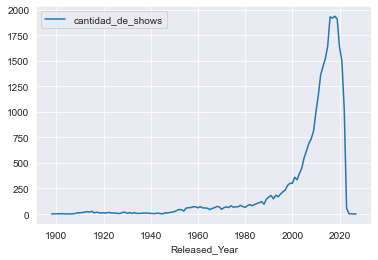

In [44]:
shows_por_anio = shows_con_merge.groupby('Released_Year').agg(
    cantidad_de_shows =  ('ID', 'nunique'))
shows_por_anio.plot()
plt.show()

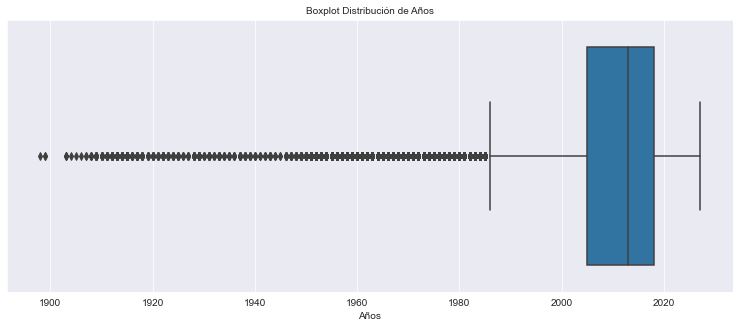

In [45]:
fig, ax1 = plt.subplots( figsize = (13, 5))
sns.boxplot(x= "Released_Year", data=shows_con_merge, ax = ax1)
ax1.set_xlabel('Años', fontsize=10)
ax1.set_title('Boxplot Distribución de Años', fontsize=10)
ax1.tick_params(labelsize=10)

In [46]:
print("La distribución de los años es:")
print('1º Cuartil: ', shows_con_merge["Released_Year"].quantile(q = 0.25))
print('2º Cuartil: ', shows_con_merge["Released_Year"].quantile(q = 0.50))
print('3º Cuartil: ', shows_con_merge["Released_Year"].quantile(q = 0.75))
print('4º Cuartil: ', shows_con_merge["Released_Year"].quantile(q = 1.00))
print('Los lanzamientos previos al año: ', round(shows_con_merge["Released_Year"].quantile(q = 0.25) -
                      1.5*(shows_con_merge["Released_Year"].quantile(q = 0.75) - shows_con_merge["Released_Year"].quantile(q = 0.25))), 'pueden tomarse como outliers. Por encontrarse muy alejados de la media del contenido bajo análisis.')


La distribución de los años es:
1º Cuartil:  2005.0
2º Cuartil:  2013.0
3º Cuartil:  2018.0
4º Cuartil:  2027.0
Los lanzamientos previos al año:  1986 pueden tomarse como outliers. Por encontrarse muy alejados de la media del contenido bajo análisis.


Para que la cantidad de outliers no sea tan extensa, se filtrarán aquellos cuya fecha de lanzamiento haya quedado muy desactualizada, es decir, los que se encuentren por debajo del límite inferior.

In [47]:
filter = shows_con_merge.Released_Year > round(shows_con_merge["Released_Year"].quantile(q = 0.25) -
                      1.5*(shows_con_merge["Released_Year"].quantile(q = 0.75) - shows_con_merge["Released_Year"].quantile(q = 0.25)))
shows_filtrado = shows_con_merge[filter]
shows_filtrado.shape

(27736, 11)

#### IMDb

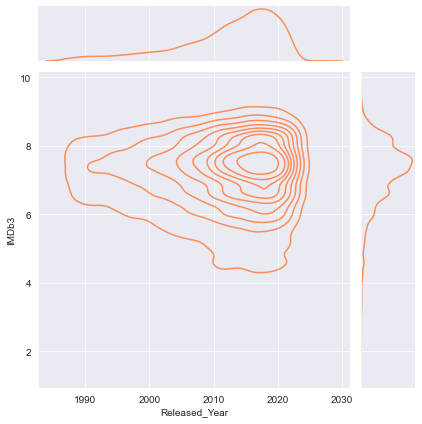

In [48]:
sns.jointplot(x='Released_Year', y='IMDb3', data=shows_filtrado, kind='kde', color="#fc8d59")

En el gráfico anterior se puede ver cómo hay una concentración de contenido entre los años 2010 y 2020, con un puntaje más bien intermedio entre 7 y 8 puntos.

#### Content Class

<AxesSubplot:>

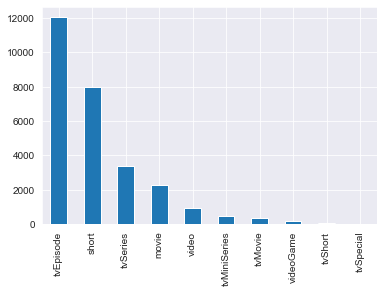

In [49]:
shows_filtrado.Content_Class.value_counts().plot(kind="bar")

In [50]:
shows_filtrado.Content_Class.value_counts()

tvEpisode       12062
short            7989
tvSeries         3395
movie            2265
video             943
tvMiniSeries      474
tvMovie           351
videoGame         200
tvShort            34
tvSpecial          23
Name: Content_Class, dtype: int64

Se utilizará el contenido más simbólico que se considera es episodios, series en general y películas.

In [51]:

shows_filtrado = shows_filtrado[(shows_filtrado.Content_Class == "tvEpisode") | (shows_filtrado.Content_Class == "tvSeries") |(shows_filtrado.Content_Class == "movie")]

#### Genres

<AxesSubplot:xlabel='Genres'>

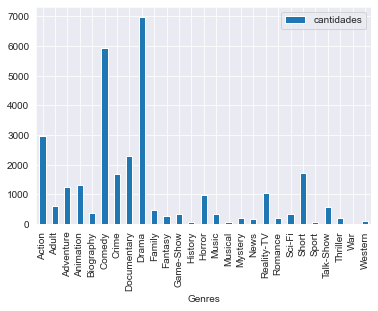

In [52]:
shows_con_merge.groupby("Genres").agg(cantidades = ("ID", "count")).plot.bar()

In [53]:
shows_filtrado.Genres.value_counts()

Comedy         4140
Drama          2810
Action         2129
Documentary    1698
Crime          1189
Reality-TV     1038
Animation       845
Adventure       840
Talk-Show       559
Family          347
Horror          326
Game-Show       312
Adult           282
Biography       224
News            166
Thriller        148
Sci-Fi          131
Music           119
Fantasy          99
Romance          67
Mystery          65
Sport            54
Short            51
History          44
Musical          21
Western          11
War               7
Name: Genres, dtype: int64

Con los géneros, se hará algo similar al tipo de contenido, dejando sólo los más frecuentes.

In [54]:
# dejamos solo los géneros mas conocidos
shows_filtrado = shows_filtrado[(shows_filtrado.Genres == "Drama") | (shows_filtrado.Genres == "Comedy") | (shows_filtrado.Genres == "Action") | (shows_filtrado.Genres == "Documentary")  | (shows_filtrado.Genres == "Crime") | (shows_filtrado.Genres == "Animation") | (shows_filtrado.Genres == "Reality-TV")]

In [55]:
print(f'Para el modelo se utilizará finalmente el dataset show_filtrado con {shows_filtrado.shape[0]} filas.')

Para el modelo se utilizará finalmente el dataset show_filtrado con 13849 filas.


## Primera aproximación al modelado

In [56]:
shows_filtrado.columns


Index(['Title', 'Netflix', 'Hulu', 'prime_video', 'disney', 'Target', 'ID',
       'Content_Class', 'Released_Year', 'Genres', 'IMDb3'],
      dtype='object')

Para el modelado, la variable *dependiente* será Target y las *independientes*:
- netflix
- hulu
- prime video
- disney+
- content class
- released year
- genres
- IMDb3

In [57]:
shows_filtrado_modelo = shows_filtrado[["Netflix", "Hulu", "prime_video", "disney","Target", "Content_Class", "Released_Year", "Genres", "IMDb3"]]

In [58]:
shows_filtrado_modelo.dtypes

Netflix            int64
Hulu               int64
prime_video        int64
disney             int64
Target            object
Content_Class     object
Released_Year      int32
Genres            object
IMDb3            float64
dtype: object

#### Primer Modelo

Primero se hará un modelo clásico, para evaluar si hay variables que es conveniente no usar en las próximas regresiones y ver como se desarrolla el modelado en general.

Para eso, primero ajustaremos la clase target con un label encoder, esto nos permitirá hacer todos los modelados que querramos por transformar los target A y TP a binario.

In [59]:
shows_filtrado_modelo.Target.value_counts()

A     9543
TP    4306
Name: Target, dtype: int64

In [60]:
from sklearn.preprocessing import LabelEncoder

shows_filtrado_modelo["Target"] = LabelEncoder().fit_transform(shows_filtrado_modelo['Target'])
shows_filtrado_modelo.head()

C:\Users\mszub\AppData\Local\Temp/ipykernel_16168/1553932228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shows_filtrado_modelo["Target"] = LabelEncoder().fit_transform(shows_filtrado_modelo['Target'])


,Netflix,Hulu,prime_video,disney,Target,Content_Class,Released_Year,Genres,IMDb3
0,1,0,0,0,0,tvSeries,2008,Crime,9.45
2,1,0,0,0,0,tvEpisode,2019,Comedy,8.60
3,1,0,0,0,0,tvEpisode,2014,Reality-TV,9.40
4,1,0,0,0,0,tvEpisode,2013,Action,9.40
5,1,0,0,0,0,tvEpisode,2022,Crime,9.20


In [61]:
shows_filtrado_modelo.Target.value_counts()

0    9543
1    4306
Name: Target, dtype: int64

In [62]:
import statsmodels.formula.api as smf
modelo = smf.logit(formula='Target ~ Netflix + Hulu + prime_video + disney + C(Content_Class) + Released_Year + C(Genres) + IMDb3 ', data=shows_filtrado_modelo).fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.562383
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                13849
Model:                          Logit   Df Residuals:                    13834
Method:                           MLE   Df Model:                           14
Date:                Tue, 06 Dec 2022   Pseudo R-squ.:                 0.09269
Time:                        13:38:34   Log-Likelihood:                -7788.4
converged:                       True   LL-Null:                       -8584.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        25.3881      4.719      5.380      0.

En primer lugar, el valor intercept de 25,38 nos dice lo siguiente: si no tuvieramos ninguno de los datos que estamos teniendo en cuenta (plataformas, año, género, etc.), hay un log-odds de 25,38 de que ese contenido sea para todo público.
Mirando los coeficientes de las otras variables, cada uno significa que, dejando una fija y todo el resto en cero, aumentar en 1 ese valor, representa un aumento o disminución de la probabilidad de que el contenido sea para todo público. El porcentaje de aumento o disminución es igual a exp(valor del coeficiente).
La variable con el coeficiente más 'fuerte' es disney. Esto significa que si el contenido a evaluar se encuentra allí, la probabilidad de que sea apto para todo público incremente notoriamente. Por otro lado, la más negativa es crime, dejando en evidencia que ese contenido claramente es para adultos u adolescentes.
Otro punto a resaltar, es que los p valores de las variables independientes utilizadas son 0 o números cercanos a este. Esto quiere decir que todas son relevantes para el análisis en mayor o menor medida.


Para seguir mejorando el análisis, primero se escalarán las variables numéricas y se encodearán las categóricas. De esta forma se buscará lograr un mejor puntaje de accuracy para que las predicciones sean de mejor calidad.

## Escalado de variables
### Tratamiento a las variables numéricas

#### Released Year

<AxesSubplot:title={'center':'Boxplot de Released_Year'}, xlabel='Released_Year'>

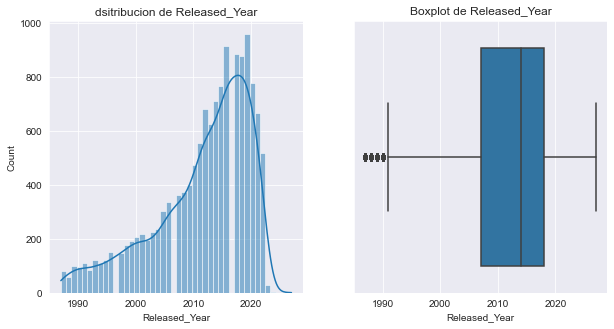

In [63]:
variable = 'Released_Year'
fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].set_title(f"dsitribucion de {variable}")
sns.histplot(data = shows_filtrado_modelo, x = f"{variable}", kde = True, ax = ax[0])
ax[1].set_title(f"Boxplot de {variable}")
sns.boxplot(data = shows_filtrado_modelo, x = f"{variable}", ax= ax[1])

Esta variable sigue una distribución con tendencia normal y presenta outliers en el extremo inferior. Se realizará un escalado robusto.

In [64]:
from sklearn.preprocessing import RobustScaler
rb_scaler = RobustScaler()
shows_filtrado_modelo["Released_Year"] = rb_scaler.fit_transform(shows_filtrado_modelo[["Released_Year"]])

C:\Users\mszub\AppData\Local\Temp/ipykernel_16168/662383843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shows_filtrado_modelo["Released_Year"] = rb_scaler.fit_transform(shows_filtrado_modelo[["Released_Year"]])


### IMDb3

<AxesSubplot:title={'center':'Boxplot de IMDb3'}, xlabel='IMDb3'>

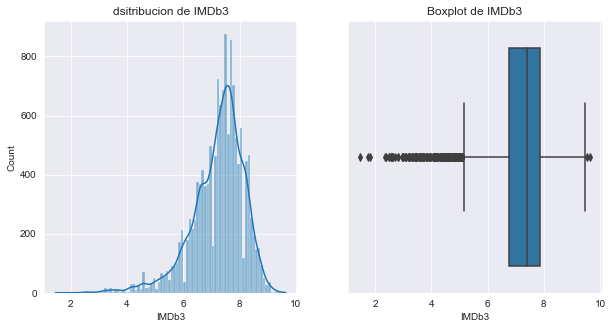

In [65]:
variable = 'IMDb3'
fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].set_title(f"dsitribucion de {variable}")
sns.histplot(data = shows_filtrado_modelo, x = f"{variable}", kde = True, ax = ax[0])
ax[1].set_title(f"Boxplot de {variable}")
sns.boxplot(data = shows_filtrado_modelo, x = f"{variable}", ax= ax[1])

Esta variable también sigue una distribución normal con outliers, por ese motivo también se hará un escalado robusto.

In [66]:
rb_scaler = RobustScaler()
shows_filtrado_modelo["IMDb3"] = rb_scaler.fit_transform(shows_filtrado_modelo[["IMDb3"]])

C:\Users\mszub\AppData\Local\Temp/ipykernel_16168/2242800925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shows_filtrado_modelo["IMDb3"] = rb_scaler.fit_transform(shows_filtrado_modelo[["IMDb3"]])


### Tratamiento variables categóricas

#### Content class

In [67]:
shows_filtrado_modelo.Content_Class.value_counts()

tvEpisode    9347
tvSeries     2718
movie        1784
Name: Content_Class, dtype: int64

En este caso se empleará one hot encoder para separar esta columna en 10, una por cada tipo. Atribuyéndole el valor 1 si el título pertenece a la categoría y 0 en caso contrario.

In [68]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
ohe.fit(shows_filtrado_modelo[['Content_Class']])
display(ohe.categories_)
display(ohe.get_feature_names_out())
content_class_encoded = ohe.transform(shows_filtrado_modelo[['Content_Class']])

shows_filtrado_modelo[ohe.get_feature_names_out()] = content_class_encoded

shows_filtrado_modelo.drop(columns='Content_Class', inplace = True)
shows_filtrado_modelo.head()

[array(['movie', 'tvEpisode', 'tvSeries'], dtype=object)]

array(['Content_Class_movie', 'Content_Class_tvEpisode',
       'Content_Class_tvSeries'], dtype=object)

C:\Users\mszub\Documents\POO\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,Netflix,Hulu,prime_video,disney,Target,Released_Year,Genres,IMDb3,Content_Class_movie,Content_Class_tvEpisode,Content_Class_tvSeries
0,1,0,0,0,0,-0.545455,Crime,1.863636,0.0,0.0,1.0
2,1,0,0,0,0,0.454545,Comedy,1.090909,0.0,1.0,0.0
3,1,0,0,0,0,0.000000,Reality-TV,1.818182,0.0,1.0,0.0
4,1,0,0,0,0,-0.090909,Action,1.818182,0.0,1.0,0.0
5,1,0,0,0,0,0.727273,Crime,1.636364,0.0,1.0,0.0


#### Genre

In [69]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(shows_filtrado_modelo[['Genres']])
display(ohe.categories_)
display(ohe.get_feature_names_out())
content_class_encoded = ohe.transform(shows_filtrado_modelo[['Genres']])

shows_filtrado_modelo[ohe.get_feature_names_out()] = content_class_encoded

shows_filtrado_modelo.drop(columns='Genres', inplace = True)
shows_filtrado_modelo.head()

[array(['Action', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
        'Reality-TV'], dtype=object)]

array(['Genres_Action', 'Genres_Animation', 'Genres_Comedy',
       'Genres_Crime', 'Genres_Documentary', 'Genres_Drama',
       'Genres_Reality-TV'], dtype=object)

,Netflix,Hulu,prime_video,disney,Target,Released_Year,IMDb3,Content_Class_movie,Content_Class_tvEpisode,Content_Class_tvSeries,Genres_Action,Genres_Animation,Genres_Comedy,Genres_Crime,Genres_Documentary,Genres_Drama,Genres_Reality-TV
0,1,0,0,0,0,-0.545455,1.863636,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,0,0,0,0,0.454545,1.090909,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,0,0,0,0,0.000000,1.818182,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,0,0,0,0,-0.090909,1.818182,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0,0,0,0,0.727273,1.636364,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Permutación de variables por relevancia

In [70]:
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
X = shows_filtrado_modelo.drop(columns=['Target'])
y = shows_filtrado_modelo["Target"]
model = LogisticRegression()
cv_results = cross_validate(model, X, y, cv = 10)
score = cv_results["test_score"].mean()
print(f"Antes de la permutación, el score del model es: {round(score,2)}")


model = LogisticRegression().fit(X,y)
permutation_score = permutation_importance(model, X, y, n_repeats=100)
importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score.importances_mean)).T,
                            columns = ['feature','feature_importance'])

print("Después de la permutación de variables, asi decrece el score en términos de variables:")
importance_df = importance_df.sort_values(by="feature_importance", ascending = False)
importance_df

Antes de la permutación, el score del model es: 0.68
Después de la permutación de variables, asi decrece el score en términos de variables:


,feature,feature_importance
3,disney,0.055025
5,IMDb3,0.014069
0,Netflix,0.004054
4,Released_Year,0.002095
2,prime_video,0.001387
10,Genres_Animation,0.001385
8,Content_Class_tvSeries,0.000952
6,Content_Class_movie,0.000668
12,Genres_Crime,0.000626
1,Hulu,0.000509


In [71]:
umbral = 0.0014
weak_features = importance_df[importance_df.feature_importance <= umbral]["feature"].values
weak_features

array(['prime_video', 'Genres_Animation', 'Content_Class_tvSeries',
       'Content_Class_movie', 'Genres_Crime', 'Hulu', 'Genres_Reality-TV',
       'Genres_Drama', 'Genres_Comedy', 'Genres_Documentary',
       'Content_Class_tvEpisode', 'Genres_Action'], dtype=object)

### Segundo Modelo
En este modelo se usarán únicamente las variables 'fuertes' calculadas anteriormente

In [72]:
from sklearn.model_selection import cross_val_score
X_strong_features = shows_filtrado_modelo.drop(columns=list(weak_features) + ["Target"])

print(f"Las variables fuertes son {list(X_strong_features.columns)}")

model = LogisticRegression()

scores = cross_val_score(model, X_strong_features, y, cv = 5)
strong_model_score = scores.mean()
print("El nuevo score es:", strong_model_score)

Las variables fuertes son ['Netflix', 'disney', 'Released_Year', 'IMDb3']
El nuevo score es: 0.7250423134940347


### Tercer Modelo: separación de datos entre train y test

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
X = shows_filtrado_modelo.drop(columns=list(weak_features) + ["Target"])
y = shows_filtrado_modelo["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2                                              , random_state=10)
model = LogisticRegression().fit(X_train,y_train)

scores = cross_val_score(model, X_test, y_test, cv=10)
base_model_score = scores.mean()
print('Accuracy on test set: ',base_model_score)


Accuracy on test set:  0.7324909747292419


##### Matriz de Confusión

In [75]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(X_test)
confusion = confusion_matrix(y_test, predictions)
print('True Positive: ', confusion[0][0], 'False Negative: ', confusion[0][1])
print('False Positive: ', confusion[1][0], 'True Negative: ', confusion[1][1])

True Positive:  1861 False Negative:  38
False Positive:  720 True Negative:  151


La matriz de confusión arroja en general buenos reusltados. Como se puede ver, la cantidad de TP es alta pero los FP también. Sin embargo, los TN son bajos en comparación con los TP.

##### Precisión

In [76]:
confusion[0,0]/(confusion[0,1]+confusion[0,0])

0.9799894681411269

El modelo tiene un alto porcentaje de clasificar a los resultados como positivos.

##### Recall

In [77]:
# recall
confusion[0,0]/(confusion[1,0]+confusion[0,0])

0.7210383572258814

Por el valor del recall, el modelo tiene un buen resultado a la hora de detectar casos positivos.

In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.72      0.98      0.83      1899
           1       0.80      0.17      0.28       871

    accuracy                           0.73      2770
   macro avg       0.76      0.58      0.56      2770
weighted avg       0.75      0.73      0.66      2770



El promedio del puntaje F1 (que muestra una combinación entre precisión y sensibilidad) es más bien bajo.

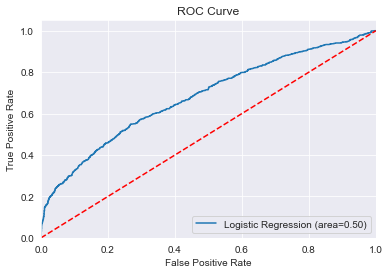

In [79]:
# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=100)

regressor = LogisticRegression()
regressor.fit(X_train, y_train)
logit_roc_auc = roc_auc_score(y_test, predictions)
fpr, tpr, thresholds = roc_curve(y_test, regressor.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area=%0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('ROC-Curve')
plt.show()

En esta curva ROC, la línea roja representa un clasificador aleatorio. Para decir que el modelo es bueno, la curva azul debe permanecer lo más alejada posible de la roja. En este caso, las curvas están separadas, lo que significa que el modelo es bueno en general.

### Cuarto Modelo: Estratificación

Ahora veremos si el accuracy del modelo mejora cuando separamos lo más equitativamente posible las variables entre el train y test. De esta forma se busca lograr que las muestras tengan la cantidad de variables distribuidas lo más equitativamente posible.

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold



X = shows_filtrado_modelo.drop(columns=['Target'])
y = shows_filtrado_modelo["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


skf = StratifiedKFold(n_splits=100)
scores = []

for train_indices, test_indices in skf.split(X, y):
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    model2 = LogisticRegression(max_iter=1000)
    model2.fit(X_train, y_train)

    scores.append(model2.score(X_test, y_test))

print(f" El nuevo valor de accuracy es: {np.array(scores).mean()}")

 El nuevo valor de accuracy es: 0.7289448441247004


En este caso el accuracy es similar al resultado en el modelo anterior. Esto puede dar la pauta de que se llegó al nivel más alto de accuracy que los datos pueden dar.

### Predicción

In [81]:
shows_filtrado_modelo.drop(columns=list(weak_features) + ["Target"]).columns

Index(['Netflix', 'disney', 'Released_Year', 'IMDb3'], dtype='object')

Los datos de la predicción a realizar se deben colocar según el orden anterior.

In [83]:
# Import the model
from sklearn.linear_model import LogisticRegression
X = shows_filtrado_modelo.drop(columns=list(weak_features) + ["Target"])
y = shows_filtrado_modelo["Target"]
model_pred = LogisticRegression(max_iter=1000)
model_pred.fit(X, y)
X_new = pd.DataFrame({'Netflix': [1], 'disney': [0], 'Released_Year': [2019], 'IMDb3': [2.8]})
prediction = model_pred.predict(X_new)[0]
prediction

0

Se realizó una predicción de contenido en Netflix, con año de estreno 2019 y un puntaje IMDb 2.8. La predicción arrojó que el contenido no sería en principio apto para todo público.

### Conclusiones

Luego de realizar un análisis exaustivo sobre qué información podría servir para la predicción, seleccionarla, modelarla y poner a prueba el modelo, se llegó a la conclusión de que el mismo tiene un accuracy medio. El nivel de falsos positivos es relativamente alto, por lo que es posible que a la hora de predecir si un contenido es apto para todo público o no, es resultado sea que sí cuando en realidad no lo es. Con los datos a disposición y las variables que resultaron relevantes, se alcanzó el máximo score posible. Tal vez, considerando otras variables que no estuvieron aquí presentes como buscadores de palabras o géneros menos específicos, se lograra un mejor puntaje.